In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency # need this for chi-squared function

In [2]:
path_dir = (os.path.dirname(os.getcwd()))

sys.path.append(path_dir)

In [3]:
from homecredit.data import HomeCredit
data = HomeCredit().get_data()['train']
data.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = data.copy()

In [5]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]

num_cols = [col for col in df.columns if (df[col].dtypes != "O")]

# Numerical variables --- Correlation

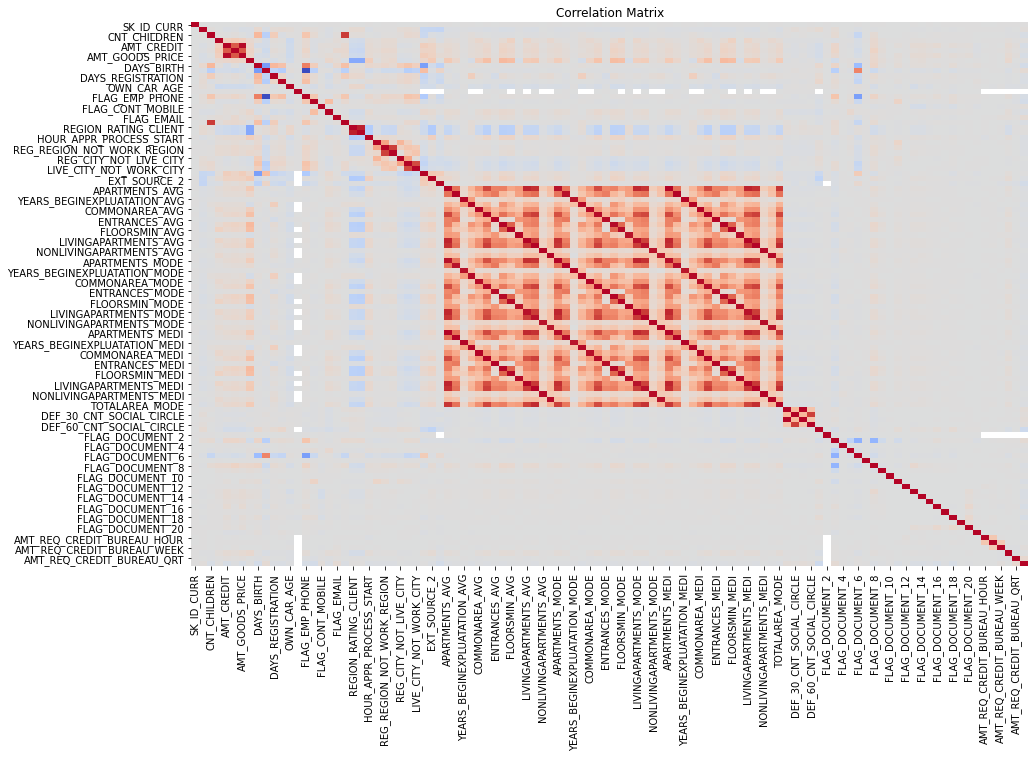

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(df.corr(), cmap='coolwarm', annot = False, label = 'small', cbar = False)

ax.set_title('Correlation Matrix')
plt.show() ;

# There are some highly correlated variables. This data set could be
# a candidate for feature reduction using Principal Component Analysis.

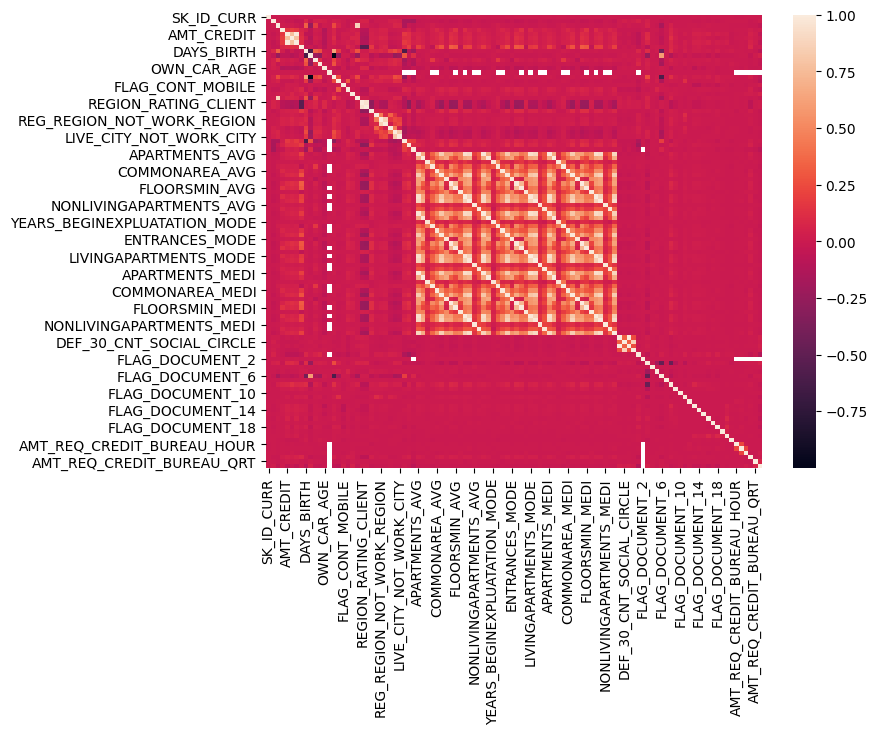

In [25]:
# correlation numeric data
fig, ax = plt.subplots(figsize=(8,6))
cor_matrix = pd.concat([df[num_cols]], axis = 1).corr()
sns.heatmap(cor_matrix)

plt.show()

# Categorical variables

## Confusion matrix

In [8]:
def confusion_matrix(df: pd.DataFrame, col1: str, col2: str):
    """
    Given a dataframe with at least
    two categorical columns, create a 
    confusion matrix of the count of the columns
    cross-counts
    """
    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )


df_corr = confusion_matrix(df, 'NAME_CONTRACT_TYPE', 'CODE_GENDER' )
df_corr

CODE_GENDER,F,M,XNA
NAME_CONTRACT_TYPE,,,
Cash loans,182800,95432,0
Revolving loans,19648,9627,4


In [9]:
chisqt = pd.crosstab(df["CODE_GENDER"], df["NAME_CONTRACT_TYPE"], margins=True)
chisqt

NAME_CONTRACT_TYPE,Cash loans,Revolving loans,All
CODE_GENDER,,,
F,182800,19648,202448
M,95432,9627,105059
XNA,0,4,4
All,278232,29279,307511


## Heatmap -- between variables entries

<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='CODE_GENDER'>

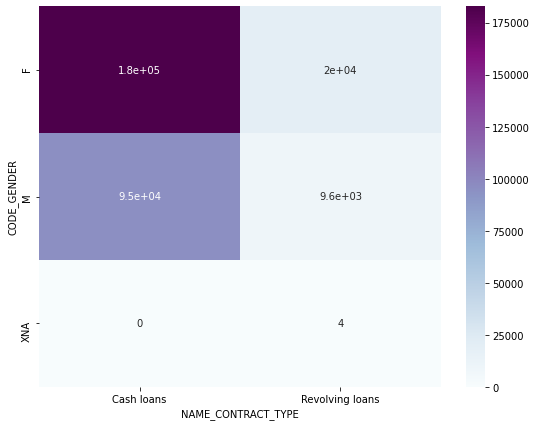

In [9]:
plt.figure(figsize = (9, 7))
sns.heatmap(pd.crosstab(df["CODE_GENDER"], df["NAME_CONTRACT_TYPE"]), annot = True,  cmap = "BuPu")

<AxesSubplot:xlabel='OCCUPATION_TYPE', ylabel='CODE_GENDER'>

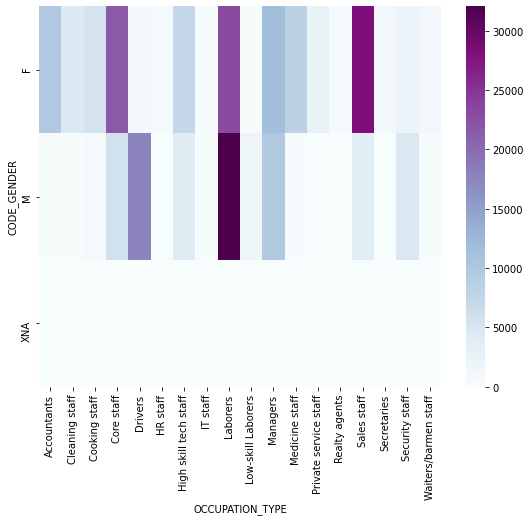

In [10]:
plt.figure(figsize = (9, 7))
sns.heatmap(pd.crosstab(df["CODE_GENDER"], df["OCCUPATION_TYPE"]), annot = False,  cmap = "BuPu")

# Categorical variables -- build function 

## chi2 test 

In [11]:
# Function to determine if variables are independent

In [31]:
def categ_corr(df, col1, col2):
    chisqt = pd.crosstab(df[col1], df[col2], margins=False)

    value =  chisqt.to_numpy()
    
    ## NULL hypothesis : variables are independent of each other.

    stat, p, dof= chi2_contingency(value)[0:3]

    #print("degree of freedom", dof)

    alpha = 0.05
    #print("p value: " + str(p)) 
    if p <= alpha: 
        print('Reject NULL HYPOTHESIS : Variables are dependent of each other') 
    else: 
        print('ACCEPT NULL HYPOTHESIS : Variables are independent of each other')
        
    
    return stat, p, dof
    
categ_corr(df, col1="CODE_GENDER", col2="NAME_CONTRACT_TYPE")    

Reject NULL HYPOTHESIS : Variables are dependent of each other


(61.57866475611076, 4.249744756595885e-14, 2)

In [32]:
categ_corr(df, col1="CODE_GENDER", col2="OCCUPATION_TYPE")    

Reject NULL HYPOTHESIS : Variables are dependent of each other


(69180.48682747532, 0.0, 34)

## Cramer's value 

In [14]:
def cramers_val(df, col1, col2): # df : dataframe
    chisqt = pd.crosstab(df[col1], df[col2], margins=False)
    value =  chisqt.to_numpy() #np.array([chisqt.iloc[0].values,
                     # chisqt.iloc[1].values]) 

    #Chi-squared test statistic, sample size, and minimum of rows and columns
    X2 = chi2_contingency(value, correction=False)[0]
    n = np.sum(value)
    minDim = min(value.shape)-1

    #calculate Cramer's V 
    V = np.sqrt((X2/n) / minDim) 
    
    return V

cramers_val(df, col1="CODE_GENDER", col2="NAME_CONTRACT_TYPE")  

0.014150924244673369

## PLot __ Heatmap of Cramer's V

In [15]:
L = len(cat_cols)
cramers_outputs = np.zeros((L,L))

for i,x in enumerate(cat_cols):
    for j,y in enumerate(cat_cols):
        result = round(cramers_val(df,x,y),4)
        cramers_outputs[i,j] = result

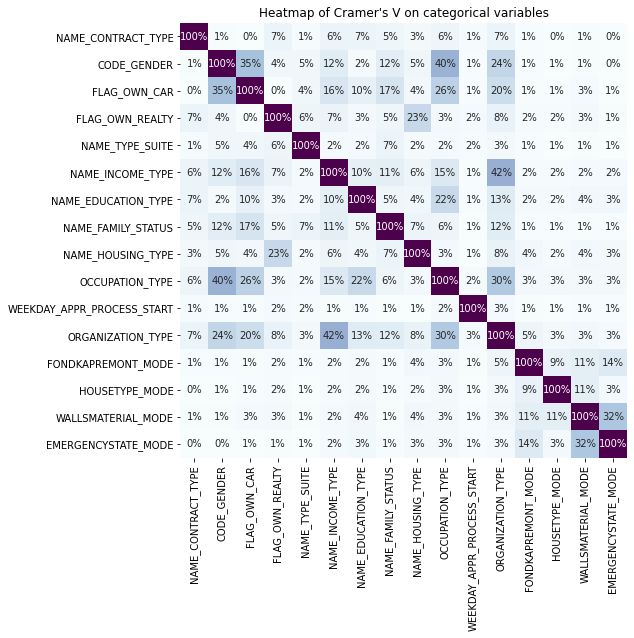

In [16]:
fig = plt.figure(figsize = (8, 8))  # instanciate figure for heat map
ax = sns.heatmap(cramers_outputs, annot = True,  cmap = "BuPu", fmt=".0%", cbar = False)
ax.set_xticklabels(cat_cols)
ax.set_yticklabels(cat_cols)
ax.tick_params(axis = 'x', labelrotation = 90)
ax.tick_params(axis = 'y', labelrotation = 0)
ax.set_title("Heatmap of Cramer's V on categorical variables");